In [4]:
%pip install pandas matplotlib numpy torch torch_geometric rdkit pubchempy networkx scikit-learn


Defaulting to user installation because normal site-packages is not writeable
  Using cached pandas-2.2.3-cp39-cp39-macosx_11_0_arm64.whl (11.3 MB)
  Using cached matplotlib-3.9.2-cp39-cp39-macosx_11_0_arm64.whl (7.8 MB)
  Using cached numpy-2.0.2-cp39-cp39-macosx_14_0_arm64.whl (5.3 MB)
  Using cached torch_geometric-2.6.1-py3-none-any.whl (1.1 MB)
  Using cached rdkit-2024.3.6-cp39-cp39-macosx_11_0_arm64.whl (26.8 MB)
  Using cached PubChemPy-1.0.4.tar.gz (29 kB)
  Using cached scikit_learn-1.5.2-cp39-cp39-macosx_12_0_arm64.whl (11.0 MB)
  Using cached tzdata-2024.2-py2.py3-none-any.whl (346 kB)
  Using cached pytz-2024.2-py2.py3-none-any.whl (508 kB)
  Using cached kiwisolver-1.4.7-cp39-cp39-macosx_11_0_arm64.whl (64 kB)
  Using cached pillow-11.0.0-cp39-cp39-macosx_11_0_arm64.whl (3.0 MB)
  Using cached fonttools-4.55.0-cp39-cp39-macosx_10_9_universal2.whl (2.8 MB)
  Using cached contourpy-1.3.0-cp39-cp39-macosx_11_0_arm64.whl (249 kB)
  Using cached pyparsing-3.2.0-py3-none-any.wh

In [1]:
import torch
from rdkit.Chem import Draw
from rdkit import Chem
from sklearn.metrics import r2_score
from torch_geometric.data import DataLoader
from torch_geometric.datasets import MoleculeNet
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
from torch_geometric.utils import to_networkx
from torch.nn import Linear
  
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import pandas as pd
import pubchempy
import rdkit
import time
import torch.nn.functional as F 
import warnings
warnings.filterwarnings("ignore")

In [2]:
dataset = MoleculeNet(root=".", name="lipo")
data = dataset[0]

In [3]:
print('\n======== Dataset =======\n')
print("Dataset type: ", type(dataset))
print("Dataset size (graphs): ", len(dataset))
print("Dataset features: ", dataset.num_features)
print("Dataset target: ", dataset.num_classes)
print("Dataset length: ", dataset.len)
print('\n======== first sample =======\n')
print("Dataset sample: ", data)
print("Sample  nodes: ", data.num_nodes)
print("Sample  edges: ", data.num_edges)


======== Dataset =======

Dataset type:  <class 'torch_geometric.datasets.molecule_net.MoleculeNet'>
Dataset size (graphs):  4200
Dataset features:  9
Dataset target:  553
Dataset length:  <bound method InMemoryDataset.len of Lipophilicity(4200)>

======== first sample =======

Dataset sample:  Data(x=[24, 9], edge_index=[2, 54], edge_attr=[54, 3], smiles='Cn1c(CN2CCN(CC2)c3ccc(Cl)cc3)nc4ccccc14', y=[1, 1])
Sample  nodes:  24
Sample  edges:  54


In [4]:
dataset[0].x[:5]

tensor([[6, 0, 4, 5, 3, 0, 4, 0, 0],
        [7, 0, 3, 5, 0, 0, 3, 1, 1],
        [6, 0, 3, 5, 0, 0, 3, 1, 1],
        [6, 0, 4, 5, 2, 0, 4, 0, 0],
        [7, 0, 3, 5, 0, 0, 4, 0, 1]])

In [5]:
dataset[0].edge_index.t()[:5]

tensor([[ 0,  1],
        [ 1,  0],
        [ 1,  2],
        [ 1, 23],
        [ 2,  1]])

In [6]:
dataset[0].y

tensor([[3.5400]])

In [7]:
sm = dataset[0]['smiles']
compound = pubchempy.get_compounds(sm, namespace='smiles')
match = compound[0]
match.iupac_name

'2-[[4-(4-chlorophenyl)piperazin-1-yl]methyl]-1-methylbenzimidazole'

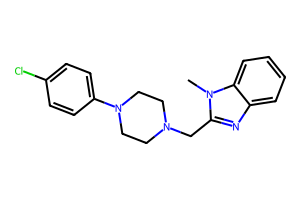

In [8]:
molecule = Draw.MolsToGridImage([Chem.MolFromSmiles(sm)], 
                molsPerRow=1, subImgSize=(300,200), returnPNG=False)
molecule.save('assets/images/first_molecule.png')
molecule

In [9]:
top_n = 12
data_attrib = []

for i in range(top_n):
    data = dataset[i]
    smiles = dataset[i]['smiles']
    data_attrib.append([data.num_nodes, data.num_edges, smiles, data.y.item()])
    
data_attr = pd.DataFrame(data_attrib)
data_attr.columns = ['num_nodes', 'num_edges', 'smiles', 'target_logD']
data_attr.head(top_n)

,num_nodes,num_edges,smiles,target_logD
0,24,54,Cn1c(CN2CCN(CC2)c3ccc(Cl)cc3)nc4ccccc14,3.54
1,33,70,COc1cc(OC)c(cc1NC(=O)CSCC(=O)O)S(=O)(=O)N2C(C)...,-1.18
2,21,46,COC(=O)[C@@H](N1CCc2sccc2C1)c3ccccc3Cl,3.69
3,28,62,OC[C@H](O)CN1C(=O)C(Cc2ccccc12)NC(=O)c3cc4cc(C...,3.37
4,28,58,Cc1cccc(C[C@H](NC(=O)c2cc(nn2C)C(C)(C)C)C(=O)N...,3.10
5,23,52,OC1(CN2CCC1CC2)C#Cc3ccc(cc3)c4ccccc4,3.14
6,35,74,COc1cc(OC)c(cc1NC(=O)CCC(=O)O)S(=O)(=O)NCc2ccc...,-0.72
7,34,72,CNc1cccc(CCOc2ccc(C[C@H](NC(=O)c3c(Cl)cccc3Cl)...,0.34
8,23,50,COc1ccc(cc1)C2=COc3cc(OC)cc(OC)c3C2=O,3.05
9,15,34,Oc1ncnc2scc(c3ccsc3)c12,2.25


In [10]:
ch_names = []
for i in data_attr["smiles"]:
    compounds = pubchempy.get_compounds(i, namespace='smiles')
    match = compounds[0]
    names = [match.iupac_name.split(')')[-1], match.iupac_name.split(']')[-1]]
    res = min(names, key=len)
    ch_names.append(res)
chem_names = ['... ' + str(i) for i in ch_names]
data_attr["name"] = chem_names
data_attr

,num_nodes,num_edges,smiles,target_logD,name
0,24,54,Cn1c(CN2CCN(CC2)c3ccc(Cl)cc3)nc4ccccc14,3.54,... -1-methylbenzimidazole
1,33,70,COc1cc(OC)c(cc1NC(=O)CSCC(=O)O)S(=O)(=O)N2C(C)...,-1.18,... sulfanylacetic acid
2,21,46,COC(=O)[C@@H](N1CCc2sccc2C1)c3ccccc3Cl,3.69,... acetate
3,28,62,OC[C@H](O)CN1C(=O)C(Cc2ccccc12)NC(=O)c3cc4cc(C...,3.37,... pyrrole-5-carboxamide
4,28,58,Cc1cccc(C[C@H](NC(=O)c2cc(nn2C)C(C)(C)C)C(=O)N...,3.10,... -2-methylpyrazole-3-carboxamide
5,23,52,OC1(CN2CCC1CC2)C#Cc3ccc(cc3)c4ccccc4,3.14,... octan-3-ol
6,35,74,COc1cc(OC)c(cc1NC(=O)CCC(=O)O)S(=O)(=O)NCc2ccc...,-0.72,... -4-oxobutanoic acid
7,34,72,CNc1cccc(CCOc2ccc(C[C@H](NC(=O)c3c(Cl)cccc3Cl)...,0.34,... propanoic acid
8,23,50,COc1ccc(cc1)C2=COc3cc(OC)cc(OC)c3C2=O,3.05,... chromen-4-one
9,15,34,Oc1ncnc2scc(c3ccsc3)c12,2.25,... pyrimidin-4-one


In [11]:
%pip install dataframe_image

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [12]:
import dataframe_image as dfi
 
df_styled =  data_attr.style.background_gradient() 
dfi.export(df_styled, "assets/images/data_attrib.png")

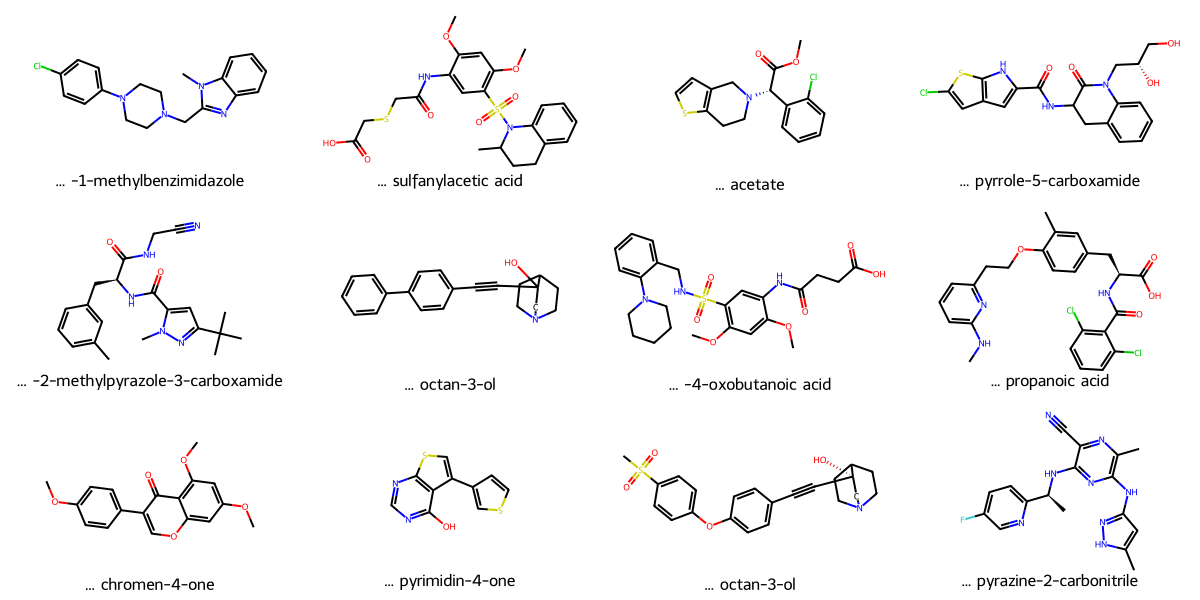

In [13]:
img = Draw.MolsToGridImage([Chem.MolFromSmiles(data_attr["smiles"][i]) for i in range(top_n)], 
                         molsPerRow=4,subImgSize=(300,200), legends=list(data_attr.name.values),
                         returnPNG=False)
img.save('assets/images/molecules.png')
img

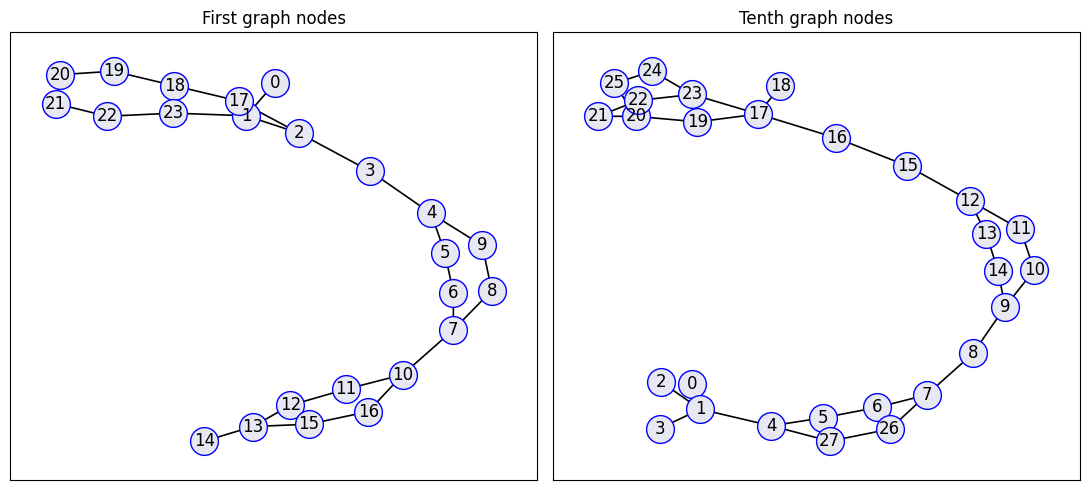

In [14]:
import matplotlib.pyplot as plt

def visualize_net(dataset):
    plt.figure(figsize=(11,5))
    ax1 = plt.subplot2grid(shape=(1, 2), loc=(0,0))
    ax2 = plt.subplot2grid(shape=(1, 2), loc=(0,1))
    ax1.set_title('First graph nodes')
    ax2.set_title('Tenth graph nodes')

    G = to_networkx(dataset[0], to_undirected=True)
    
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=14), with_labels=True,
                     node_color=[0.91, 0.91, 0.95], node_size=400, width=1.2,
                     edgecolors='blue', cmap="Set2", ax=ax1)
    
    G = to_networkx(dataset[10], to_undirected=True)
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=14), with_labels=True,
                    node_color=[0.91, 0.91, 0.95], node_size=400, width=1.2,
                    edgecolors='blue', cmap="Set2", ax=ax2)
    plt.tight_layout()
    plt.savefig('assets/images/graphs.png', bbox_inches='tight')
    plt.show()    
    

visualize_net(dataset)

In [15]:
embedding_size = 64
class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        torch.manual_seed(42)

        self.initial_conv = GCNConv(data.num_features, embedding_size)
        self.conv1 = GCNConv(embedding_size, embedding_size)
        self.conv2 = GCNConv(embedding_size, embedding_size)
        self.conv3 = GCNConv(embedding_size, embedding_size)
        self.out = Linear(embedding_size*2, 1)

    def forward(self, x, edge_index, batch_index):
        hidden = self.initial_conv(x, edge_index)
        hidden = F.tanh(hidden)

        hidden = self.conv1(hidden, edge_index)
        hidden = F.tanh(hidden)
        hidden = self.conv2(hidden, edge_index)
        hidden = F.tanh(hidden)
        hidden = self.conv3(hidden, edge_index)
        hidden = F.tanh(hidden)
          
        hidden = torch.cat([gmp(hidden, batch_index), 
                            gap(hidden, batch_index)], dim=1)

        out = self.out(hidden)

        return out, hidden

model = GCN()
print(model)
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))


GCN(
  (initial_conv): GCNConv(9, 64)
  (conv1): GCNConv(64, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (out): Linear(in_features=128, out_features=1, bias=True)
)
Number of parameters:  13249


In [16]:
%pip install numpy==2

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [17]:
from torch_geometric.data import DataLoader
import warnings
warnings.filterwarnings("ignore")

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0007)  

def r2_accuracy(pred_y, y):
  score = r2_score(y, pred_y)
  return round(score, 2) * 100

embeddings = []
losses = []
accuracies = []
outputs = []
targets = []

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

data_size = len(dataset)
NUM_GRAPHS_PER_BATCH = 32 
NUM_EPOCHS = 500  

torch.manual_seed(12345)

dataset = dataset.shuffle()

train_dataset = dataset[:int(data_size * 0.27)] 
test_dataset = dataset[int(data_size * 0.73):] 

loader = DataLoader(train_dataset, batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=NUM_GRAPHS_PER_BATCH, shuffle=False)

print('\n======== data distribution =======\n')
print("Size of training data: {} graphs".format(len(train_dataset)))
print("Size of testing data: {} graphs".format(len(test_dataset)))

def train(data):
  for batch in loader:
    batch.to(device)  
    optimizer.zero_grad() 
    pred, embedding = model(batch.x.float(), batch.edge_index, batch.batch) 
    loss = loss_fn(pred, batch.y)     
    acc = r2_accuracy(pred.detach().numpy(), batch.y.detach().numpy())

    loss.backward()  
    optimizer.step()   
  return loss, acc, pred, batch.y, embedding

print('\n======== Starting training ... =======\n')
start_time = time.time()

losses = []
for epoch in range(NUM_EPOCHS):
  loss, acc, pred, target, h = train(data)
  losses.append(loss)
  accuracies.append(acc)
  outputs.append(pred)
  targets.append(target)
  
  if epoch % 100 == 0:
    print(f'Epoch {epoch:>3} | Loss: {loss:.5f} | Acc: {acc:.2f}%')

print("\nTraining done!\n")
elapsed = time.time() - start_time
minutes_e = elapsed // 60
print("--- training took:  %s minutes ---" % (minutes_e))



======== data distribution =======

Size of training data: 1134 graphs
Size of testing data: 1134 graphs

======== Starting training ... =======

Epoch   0 | Loss: 1.44535 | Acc: -2.00%
Epoch 100 | Loss: 0.75945 | Acc: 50.00%
Epoch 200 | Loss: 0.46549 | Acc: 67.00%
Epoch 300 | Loss: 0.24584 | Acc: 78.00%
Epoch 400 | Loss: 0.20736 | Acc: 81.00%

Training done!

--- training took:  55.0 minutes ---


In [ ]:
torch.save(model, "trained_model.pth")
print("Trained model saved successfully!")

Trained model saved successfully!


In [ ]:
import torch

model = torch.load("trained_model.pth")
model.eval()  
print("Trained model loaded and ready for use!")

Trained model loaded and ready for use!


In [56]:
losses_float = [float(loss.cpu().detach().numpy()) for loss in losses] 
losses_np = np.array([x.item() for x in losses])
outs = [i[0] for i in outputs]
outputs_np = np.array([x.item() for x in outs])
targs = [i[0] for i in targets]
targets_np = np.array([x.item() for x in targs])

results = pd.concat([pd.DataFrame(losses_np),
                     pd.DataFrame(accuracies),
                     pd.DataFrame(outputs_np),
                     pd.DataFrame(targets_np)], axis= 1)
results.columns = ['losses', 'accuracy', 'pred', 'target']
results.head()

,losses,accuracy,pred,target
0,0.087865,95.0,2.944395,2.76
1,0.057329,96.0,3.660836,3.37
2,0.053685,94.0,2.529474,2.50
3,0.076316,97.0,4.681057,4.10
4,0.123415,91.0,2.952816,2.96


In [57]:
ymin, ymax = np.floor(min(results[[ 'pred', 'target']].min())),\
    round(max(results[[ 'pred', 'target']].max()))

In [ ]:
training_acc = r2_accuracy(results["target"], results["pred"])

training_acc_1st_20 = r2_accuracy(results["target"][:20], results["pred"][:20])

training_acc_last_20 = r2_accuracy(results["target"][-20:], results["pred"][-20:])

print("Training accuracy: {}%".format(round(training_acc, 2)))
print("1st 20 Training accuracy: {}%".format(round(training_acc_1st_20, 2)))
print("Last 20 Training accuracy: {}%".format(round(training_acc_last_20, 2)))

Training accuracy: 99.0%
1st 20 Training accuracy: 98.0%
Last 20 Training accuracy: 99.0%


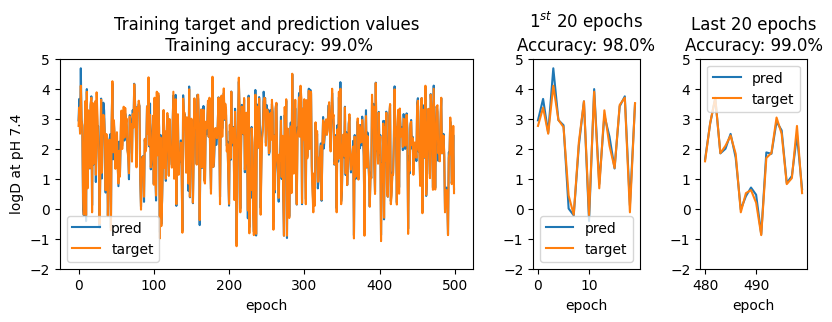

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,6))
 
ax1 = plt.subplot2grid(shape=(2, 28), loc=(0,0), colspan=15)
ax2 = plt.subplot2grid(shape=(2, 28), loc=(0,17), colspan=4)
ax3 = plt.subplot2grid(shape=(2, 28), loc=(0,23), colspan=4)


results[[ 'pred', 'target']].plot(title='Training target and prediction values\n Training accuracy: ' + str(round(training_acc, 2) )+ '%',
                                  xlabel='epoch', ylabel = 'logD at pH 7.4', ax=ax1, ylim = (ymin, ymax) ) 
results[[ 'pred', 'target']][:20].plot(title="$1^{st}$ 20 epochs\nAccuracy: " + str(round(training_acc_1st_20, 2)) +'%',
                                       xlabel='epoch', ax=ax2, ylim = (ymin, ymax))
results[[ 'pred', 'target']][-20:].plot(title="Last 20 epochs\nAccuracy: " + str(round(training_acc_last_20, 2)) +'%',
                                       xlabel='epoch', ax=ax3, ylim = (ymin, ymax))
fig.savefig('assets/images/pred_vs_targ.png', bbox_inches='tight')

<!-- <div style="text-align:left;color:Maroon">
    <h4>More performance metrics.</h4>
</div>

<div style="text-align:left;color:Maroon">
    <h5>Plot RMSE (loss) and accuracy.</h5>
</div>
  -->

In [60]:
%pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


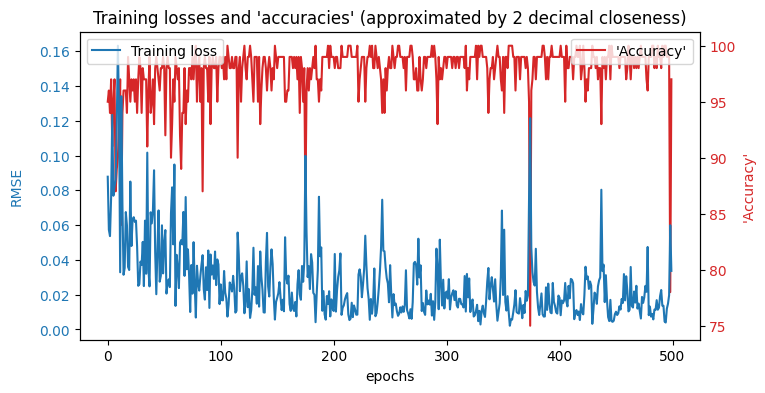

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax1 = plt.subplots(figsize=(8,4))

color1 = 'tab:red'
ax1.set_xlabel('epochs')

ax1.tick_params(axis='y', labelcolor=color1)
sns.lineplot(data=results.accuracy, label="'Accuracy'", color=color1, ax=ax1)
plt.legend(loc='upper right')

ax2 = ax1.twinx() 

color2 = 'tab:blue'
ax1.set_ylabel('RMSE' , color=color2, labelpad=40)
ax2.set_ylabel("'Accuracy'", color=color1, labelpad=30)  

ax2.tick_params(axis='y', labelcolor=color2)
sns.lineplot(data=losses_float, label='Training loss', color=color2, ax=ax2)
plt.legend(loc='upper left')

ax1.yaxis.tick_right()
ax2.yaxis.tick_left()

plt.title("Training losses and 'accuracies' (approximated by 2 decimal closeness)")

plt.show()
fig.tight_layout()
fig.savefig('assets/images/losses_and_accuracies.png', bbox_inches='tight')

In [ ]:
import pandas as pd 

test_batch = next(iter(test_loader))
with torch.no_grad():
    test_batch.to(device)
    pred, embed = model(test_batch.x.float(), test_batch.edge_index, test_batch.batch) 
    df = pd.DataFrame()
    df["y"] = test_batch.y.tolist()
    df["y_pred"] = pred.tolist()
df["real"] = df["y"].apply(lambda row: row[0])
df["pred"] = df["y_pred"].apply(lambda row: row[0])
df.head()

,y,y_pred,real,pred
0,[1.4199999570846558],[-0.07994627952575684],1.42,-0.079946
1,[3.0899999141693115],[2.7973453998565674],3.09,2.797345
2,[2.9600000381469727],[2.998802661895752],2.96,2.998803
3,[2.049999952316284],[2.3607611656188965],2.05,2.360761
4,[0.28999999165534973],[0.2073662281036377],0.29,0.207366


In [52]:
test_acc = r2_accuracy(df["real"], df["pred"])
test_acc_1st_20 = r2_accuracy(df["real"][:20], df["pred"][:20])

print("Test accuracy is {}%".format(round(test_acc, 2) ))
print("1st 20 test accuracy is {}%".format(round(test_acc_1st_20, 2)))

Test accuracy is 75.0%
1st 20 test accuracy is 78.0%


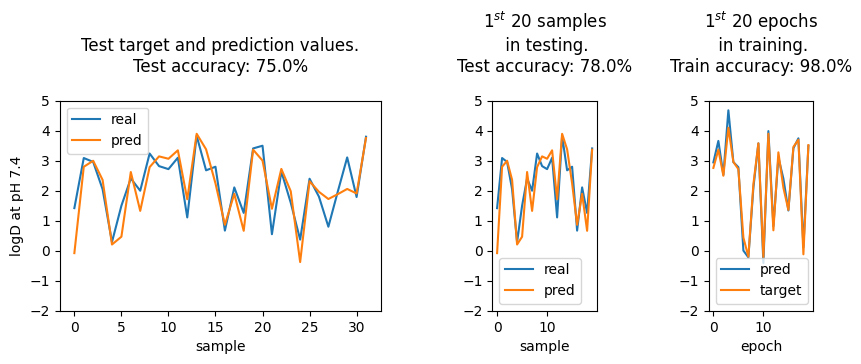

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (10,6))

ax1 = plt.subplot2grid(shape=(2, 36), loc=(0,0), colspan=15)
ax2 = plt.subplot2grid(shape=(2, 36), loc=(0,20), colspan=5)
ax3 = plt.subplot2grid(shape=(2, 36), loc=(0,30), colspan=5)

test_title = "Test target and prediction values." + "\nTest accuracy: {}%\n".format(round(test_acc, 2))
df[["real", "pred"]].plot(title=test_title, xlabel='sample', ylabel = 'logD at pH 7.4',
                          ax=ax1, ylim = (ymin, ymax) ) 

test_title_1st_20 = "$1^{st}$ 20 samples\n in testing." + "\nTest accuracy: {}%\n".format(round(test_acc_1st_20, 2))  
df[["real", "pred"]][:20].plot(title=test_title_1st_20, xlabel='sample',
                                       ax=ax2, ylim = (ymin, ymax))

train_title = "$1^{st}$ 20 epochs\n in training." + "\nTrain accuracy: {}%\n".format(round(training_acc_1st_20,2))  
results[[ 'pred', 'target']][:20].plot(title=train_title,
                                       xlabel='epoch',
                                       ax=ax3, ylim = (ymin, ymax))
fig.savefig('assets/images/pred_vs_targ_trained.png', bbox_inches='tight')